In [1]:
import h5py 
import numpy as np 
# -- astropy--
from astropy.io import fits
from astropy.table import Table as aTable
# -- feasibgs -- 
from feasibgs import util as UT

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [4]:
iblocks = [1] #, 2, 3, 4, 5]
nblock = 64

In [5]:
# read in the block catalog
dir_spec = ''.join([UT.dat_dir(), 'spectra/gamadr3_legacydr7/']) 

for iblock in iblocks: 
    fblock = h5py.File(''.join([dir_spec, 'g15.mockexp_block.', str(iblock), 'of', str(nblock), '.hdf5']), 'r') 
    if iblock == iblocks[0]: 
        block = {}
        for g in fblock.keys():
            block[g] = {} 
            for k in fblock[g].keys(): 
                block[g][k] = fblock[g][k].value
    else: 
        for g in fblock.keys(): 
            for k in fblock[g].keys(): 
                block[g][k] = np.concatenate([block[g][k], fblock[g][k].value])
    magnorm_flag = block['forwardmodel']['magnorm_flag']    
    fblock.close()

In [6]:
r_mag_legacy = UT.flux2mag(block['legacy-photo']['flux_r'])#, method='log')
ztrue = block['gama-spec']['z']

In [7]:
# read exposures from file
fexp = h5py.File(''.join([UT.dat_dir(), 'bgs_survey_exposures.withsun.hdf5']), 'r')
exps = {} 
for k in fexp.keys(): 
    exps[k] = fexp[k].value

In [8]:
def zsuccess(zrr, ztrue, zwarn): 
    dz_1pz = np.abs(ztrue - zrr)/(1.+ztrue)
    return (dz_1pz < 0.003) & (zwarn == 0)# & magnorm_flag

In [9]:
def zsuccess_iexp(iexp, iblocks, ztrue=None, sky='old'): 
    z_rr, z_warn = [], [] 
    for iblock in iblocks: 
        if sky == 'old': 
            f_rr = ''.join([dir_spec, 'g15.sim_spectra.mockexp_block.', str(iblock), 'of', str(nblock), '.480.iexp', str(iexp), '.KSsky.rr.fits'])
        elif sky == 'new':
            f_rr = ''.join([dir_spec, 'g15.sim_spectra.mockexp_block.', str(iblock), 'of', str(nblock), '.480.iexp', str(iexp), '.newKSsky.rr.fits'])
        z_iblock = fits.open(f_rr)[1].data
        z_rr.append(z_iblock['Z'])
        z_warn.append(z_iblock['ZWARN'])
    return zsuccess(np.concatenate(z_rr), ztrue, np.concatenate(z_warn))

In [10]:
ks_zsuccess0 = zsuccess_iexp(0, iblocks, ztrue=ztrue, sky='old') #zsuccess(zblock_ks0['Z'], ztrue, zblock_ks0['ZWARN'])
ks_zsuccess_twi = zsuccess_iexp(2268, iblocks, ztrue=ztrue, sky='old') #zsuccess(zblock_ks_twi['Z'], ztrue, zblock_ks_twi['ZWARN'])
#ks_zsuccess1 = zsuccess(zblock_ks1['Z'], ztrue, zblock_ks1['ZWARN'])
#ks_zsuccess2 = zsuccess(zblock_ks2['Z'], ztrue, zblock_ks2['ZWARN'])

newks_zsuccess0 = zsuccess_iexp(0, iblocks, ztrue=ztrue, sky='new') #zsuccess(zblock_newks0['Z'], ztrue, zblock_newks0['ZWARN'])
newks_zsuccess_twi = zsuccess_iexp(2268, iblocks, ztrue=ztrue, sky='new') #zsuccess(zblock_newks_twi['Z'], ztrue, zblock_newks_twi['ZWARN'])
#newks_zsuccess1 = zsuccess(zblock_newks1['Z'], ztrue, zblock_newks1['ZWARN'])
#newks_zsuccess2 = zsuccess(zblock_newks2['Z'], ztrue, zblock_newks2['ZWARN'])

In [11]:
def zsuccess_rate_magnorm(prop, zsuccess_cond, magnorm_flag, range=None, nbins=20, bin_min=2):
    """ 
    """
    h0, bins = np.histogram(prop[magnorm_flag], bins=nbins, range=range)
    hv, _ = np.histogram(prop[magnorm_flag], bins=bins, weights=prop[magnorm_flag])
    h1, _ = np.histogram(prop[zsuccess_cond & magnorm_flag], bins=bins)
    
    good = h0 > bin_min
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]

    vv = hv / h0 # weighted mean of var
    
    def _eff(k, n):
        eff = k.astype("float") / (n.astype('float') + (n==0))
        efferr = np.sqrt(eff * (1 - eff)) / np.sqrt(n.astype('float') + (n == 0))
        return eff, efferr
    
    e1, ee1 = _eff(h1, h0)
    return vv, e1, ee1

In [12]:
def zsuccess_faint(rmag, zsuccess_cond, magnorm_flag, rmag_cut=19.5): 
    ''' redshift success rate below rmag=(default 19.5)
    '''
    faint = (rmag > rmag_cut) & magnorm_flag
    faint_success = (faint & zsuccess_cond & magnorm_flag)
    
    return float(np.sum(faint_success))/float(np.sum(faint))

def zsuccess_bright(rmag, zsuccess_cond, magnorm_flag, rmag_cut=19.5): 
    ''' redshift success rate below rmag=(default 19.5)
    '''
    faint = (rmag < rmag_cut) & magnorm_flag
    faint_success = (faint & zsuccess_cond & magnorm_flag)
    
    return float(np.sum(faint_success))/float(np.sum(faint))

-- Moon Ill. = 0.802702, Alt. = 31.072670, Sep. = 54.793890; Sun Alt. = -22.971529, Sep. = 79.898866 --
KS sky: (z success rate r < 19.5) = 0.974326
KS sky: (z success rate r > 19.5) = 0.962791
KS sky: (z success rate r > 20.) = 0.692308
KS sky: (z success rate r > 20.5) = 0.500000
---
new KS sky: (z success rate r < 19.5) = 0.967908
new KS sky: (z success rate r > 19.5) = 0.953488
new KS sky: (z success rate r > 20.) = 0.692308
new KS sky: (z success rate r > 20.5) = 0.500000

-- Moon Ill. = 0.697425, Alt. = -38.420428, Sep. = 140.772338; Sun Alt. = -13.081944, Sep. = 43.751247 --
KS sky: (z success rate r < 19.5) = 0.979461
KS sky: (z success rate r > 19.5) = 0.976744
KS sky: (z success rate r > 20.) = 0.846154
KS sky: (z success rate r > 20.5) = 0.500000
---
new KS sky: (z success rate r < 19.5) = 0.973042
new KS sky: (z success rate r > 19.5) = 0.948837
new KS sky: (z success rate r > 20.) = 0.692308
new KS sky: (z success rate r > 20.5) = 0.500000



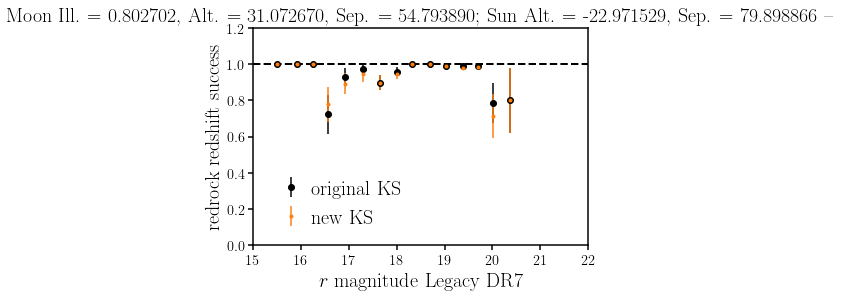

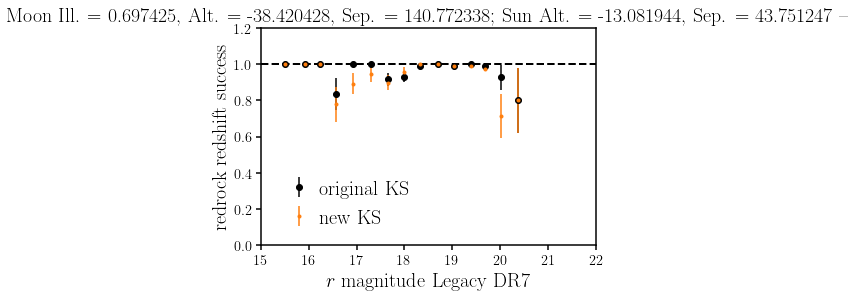

In [13]:
for iexp, ks_zsuc, newks_zsuc in zip([0, 2268], #100, 200], 
                                     [ks_zsuccess0, ks_zsuccess_twi], 
                                     [newks_zsuccess0, newks_zsuccess_twi]): 
    fig = plt.figure()
    sub = fig.add_subplot(111)
    sub.plot([15., 22.], [1., 1.], c='k', ls='--', lw=2)
    mm, e1, ee1 = zsuccess_rate_magnorm(r_mag_legacy, ks_zsuc, magnorm_flag, nbins=20, range=[15., 22.])
    sub.errorbar(mm, e1, ee1, color='k', fmt='o', label='original KS')
    print("-- Moon Ill. = %f, Alt. = %f, Sep. = %f; Sun Alt. = %f, Sep. = %f --" % (exps['MOONFRAC'][iexp], exps['MOONALT'][iexp], exps['MOONSEP'][iexp], exps['SUNALT'][iexp], exps['SUNSEP'][iexp]))
    print('KS sky: (z success rate r < 19.5) = %f' % zsuccess_bright(r_mag_legacy, ks_zsuc, magnorm_flag, rmag_cut=19.5))
    print('KS sky: (z success rate r > 19.5) = %f' % zsuccess_faint(r_mag_legacy, ks_zsuc, magnorm_flag, rmag_cut=19.5))
    print('KS sky: (z success rate r > 20.) = %f' % zsuccess_faint(r_mag_legacy, ks_zsuc, magnorm_flag, rmag_cut=20.))
    print('KS sky: (z success rate r > 20.5) = %f' % zsuccess_faint(r_mag_legacy, ks_zsuc, magnorm_flag, rmag_cut=20.5))
    print('---')
    
    mm, e1, ee1 = zsuccess_rate_magnorm(r_mag_legacy, newks_zsuc, magnorm_flag, nbins=20, range=[15., 22.])
    sub.errorbar(mm, e1, ee1, fmt='.C1', label='new KS')
    print('new KS sky: (z success rate r < 19.5) = %f' % zsuccess_bright(r_mag_legacy, newks_zsuc, magnorm_flag, rmag_cut=19.5))
    print('new KS sky: (z success rate r > 19.5) = %f' % zsuccess_faint(r_mag_legacy, newks_zsuc, magnorm_flag, rmag_cut=19.5))
    print('new KS sky: (z success rate r > 20.) = %f' % zsuccess_faint(r_mag_legacy, newks_zsuc, magnorm_flag, rmag_cut=20.))
    print('new KS sky: (z success rate r > 20.5) = %f' % zsuccess_faint(r_mag_legacy, newks_zsuc, magnorm_flag, rmag_cut=20.5))
    print('')
    
    sub.set_xlabel(r'$r$ magnitude Legacy DR7', fontsize=20)
    sub.set_xlim([15., 22.]) 
    sub.set_ylabel(r'redrock redshift success', fontsize=20)
    sub.set_ylim([0., 1.2])
    sub.legend(loc='lower left', handletextpad=0., prop={'size': 20})
    sub.set_title(("Moon Ill. = %f, Alt. = %f, Sep. = %f; Sun Alt. = %f, Sep. = %f --" % (exps['MOONFRAC'][iexp], exps['MOONALT'][iexp], exps['MOONSEP'][iexp], exps['SUNALT'][iexp], exps['SUNSEP'][iexp])), fontsize=20)

In [25]:
# read in meta data spaced exposures
bgs_exps = np.loadtxt(''.join([UT.dat_dir(), 'bgs_survey_exposures.withsun.iexp_metabin.dat']))
bgs_exps = bgs_exps.astype(int)
print("%i exposures" % len(bgs_exps))

50 exposures


-- Moon Ill. = 0.740295, Alt. = 5.944621, Sep. = 117.061938; Sun Alt. = -30.739410, Sep. = 120.293201 --
KS sky: (z success rate r < 19.5) = 0.975610
KS sky: (z success rate r > 19.5) = 0.967442
KS sky: (z success rate r > 20.) = 0.692308
KS sky: (z success rate r > 20.5) = 0.500000
---
new KS sky: (z success rate r < 19.5) = 0.973042
new KS sky: (z success rate r > 19.5) = 0.953488
new KS sky: (z success rate r > 20.) = 0.692308
new KS sky: (z success rate r > 20.5) = 0.500000

-- Moon Ill. = 0.881721, Alt. = 50.526725, Sep. = 72.039359; Sun Alt. = -73.567922, Sep. = 142.290671 --
KS sky: (z success rate r < 19.5) = 0.971759
KS sky: (z success rate r > 19.5) = 0.948837
KS sky: (z success rate r > 20.) = 0.692308
KS sky: (z success rate r > 20.5) = 0.500000
---
new KS sky: (z success rate r < 19.5) = 0.962773
new KS sky: (z success rate r > 19.5) = 0.916279
new KS sky: (z success rate r > 20.) = 0.615385
new KS sky: (z success rate r > 20.5) = 0.500000

-- Moon Ill. = 0.619783, Alt. = 

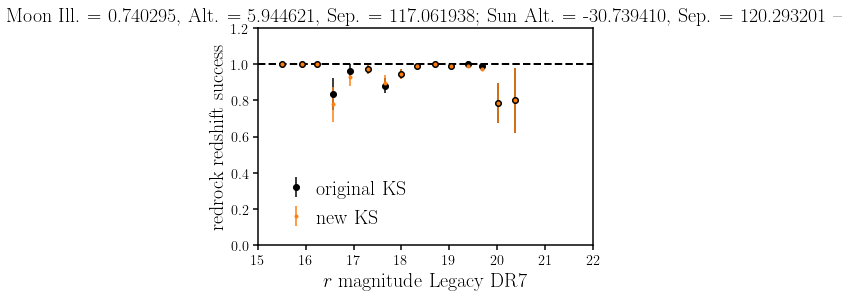

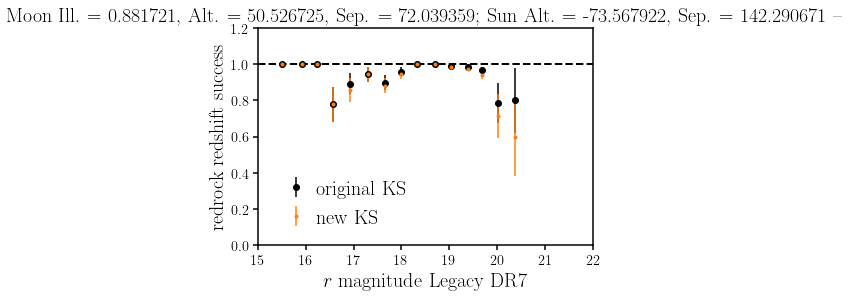

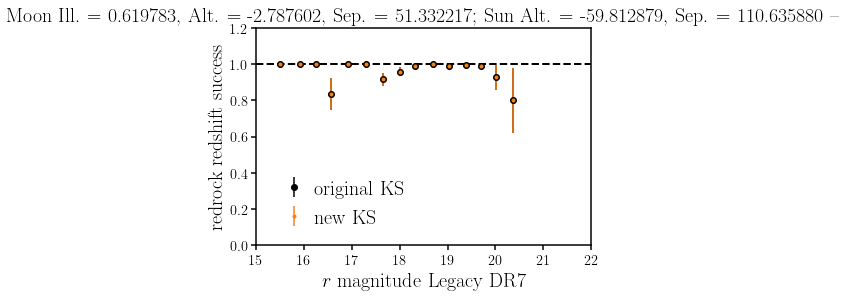

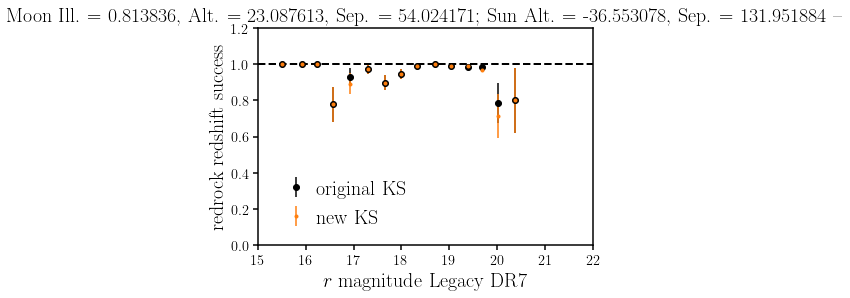

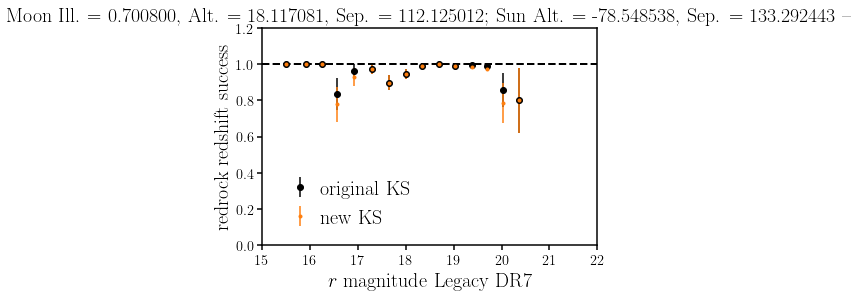

In [23]:
for iexp in bgs_exps[:5]: 
    ks_zs = zsuccess_iexp(iexp, iblocks, ztrue=ztrue, sky='old') #zsuccess(zblock_ks0['Z'], ztrue, zblock_ks0['ZWARN'])
    newks_zs = zsuccess_iexp(iexp, iblocks, ztrue=ztrue, sky='new') #zsuccess(zblock_newks0['Z'], ztrue, zblock_newks0['ZWARN'])
    
    fig = plt.figure()
    sub = fig.add_subplot(111)
    sub.plot([15., 22.], [1., 1.], c='k', ls='--', lw=2)
    mm, e1, ee1 = zsuccess_rate_magnorm(r_mag_legacy, ks_zs, magnorm_flag, nbins=20, range=[15., 22.])
    sub.errorbar(mm, e1, ee1, color='k', fmt='o', label='original KS')
    print("-- Moon Ill. = %f, Alt. = %f, Sep. = %f; Sun Alt. = %f, Sep. = %f --" % (exps['MOONFRAC'][iexp], exps['MOONALT'][iexp], exps['MOONSEP'][iexp], exps['SUNALT'][iexp], exps['SUNSEP'][iexp]))
    print('KS sky: (z success rate r < 19.5) = %f' % zsuccess_bright(r_mag_legacy, ks_zs, magnorm_flag, rmag_cut=19.5))
    print('KS sky: (z success rate r > 19.5) = %f' % zsuccess_faint(r_mag_legacy, ks_zs, magnorm_flag, rmag_cut=19.5))
    print('KS sky: (z success rate r > 20.) = %f' % zsuccess_faint(r_mag_legacy, ks_zs, magnorm_flag, rmag_cut=20.))
    print('KS sky: (z success rate r > 20.5) = %f' % zsuccess_faint(r_mag_legacy, ks_zs, magnorm_flag, rmag_cut=20.5))
    print('---')
    
    mm, e1, ee1 = zsuccess_rate_magnorm(r_mag_legacy, newks_zs, magnorm_flag, nbins=20, range=[15., 22.])
    sub.errorbar(mm, e1, ee1, fmt='.C1', label='new KS')
    print('new KS sky: (z success rate r < 19.5) = %f' % zsuccess_bright(r_mag_legacy, newks_zs, magnorm_flag, rmag_cut=19.5))
    print('new KS sky: (z success rate r > 19.5) = %f' % zsuccess_faint(r_mag_legacy, newks_zs, magnorm_flag, rmag_cut=19.5))
    print('new KS sky: (z success rate r > 20.) = %f' % zsuccess_faint(r_mag_legacy, newks_zs, magnorm_flag, rmag_cut=20.))
    print('new KS sky: (z success rate r > 20.5) = %f' % zsuccess_faint(r_mag_legacy, newks_zs, magnorm_flag, rmag_cut=20.5))
    print('')
    
    sub.set_xlabel(r'$r$ magnitude Legacy DR7', fontsize=20)
    sub.set_xlim([15., 22.]) 
    sub.set_ylabel(r'redrock redshift success', fontsize=20)
    sub.set_ylim([0., 1.2])
    sub.legend(loc='lower left', handletextpad=0., prop={'size': 20})
    sub.set_title(("Moon Ill. = %f, Alt. = %f, Sep. = %f; Sun Alt. = %f, Sep. = %f --" % (exps['MOONFRAC'][iexp], exps['MOONALT'][iexp], exps['MOONSEP'][iexp], exps['SUNALT'][iexp], exps['SUNSEP'][iexp])), fontsize=20)

In [54]:
zs_19_5_old, zs_20_0_old, zs_20_5_old = [], [], [] 
zs_19_5_new, zs_20_0_new, zs_20_5_new = [], [], [] 

bgs_iexps = bgs_exps[:28]

for iexp in bgs_iexps: 
    ks_zs = zsuccess_iexp(iexp, iblocks, ztrue=ztrue, sky='old') #zsuccess(zblock_ks0['Z'], ztrue, zblock_ks0['ZWARN'])
    newks_zs = zsuccess_iexp(iexp, iblocks, ztrue=ztrue, sky='new') #zsuccess(zblock_newks0['Z'], ztrue, zblock_newks0['ZWARN'])
    
    zs_19_5_old.append(zsuccess_faint(r_mag_legacy, ks_zs, magnorm_flag, rmag_cut=19.5))
    zs_20_0_old.append(zsuccess_faint(r_mag_legacy, ks_zs, magnorm_flag, rmag_cut=20.0))
    zs_20_5_old.append(zsuccess_faint(r_mag_legacy, ks_zs, magnorm_flag, rmag_cut=20.5))

    zs_19_5_new.append(zsuccess_faint(r_mag_legacy, newks_zs, magnorm_flag, rmag_cut=19.5))
    zs_20_0_new.append(zsuccess_faint(r_mag_legacy, newks_zs, magnorm_flag, rmag_cut=20.0))
    zs_20_5_new.append(zsuccess_faint(r_mag_legacy, newks_zs, magnorm_flag, rmag_cut=20.5))
zs_19_5_old = np.array(zs_19_5_old)
zs_20_0_old = np.array(zs_20_0_old)
zs_20_5_old = np.array(zs_20_5_old)

zs_19_5_new = np.array(zs_19_5_new)
zs_20_0_new = np.array(zs_20_0_new)
zs_20_5_new = np.array(zs_20_5_new)

Text(0.5,1,'($z$ success rate w/ old sky model) - ($z$ success rate w/ new sky model) $r > 19.5$')

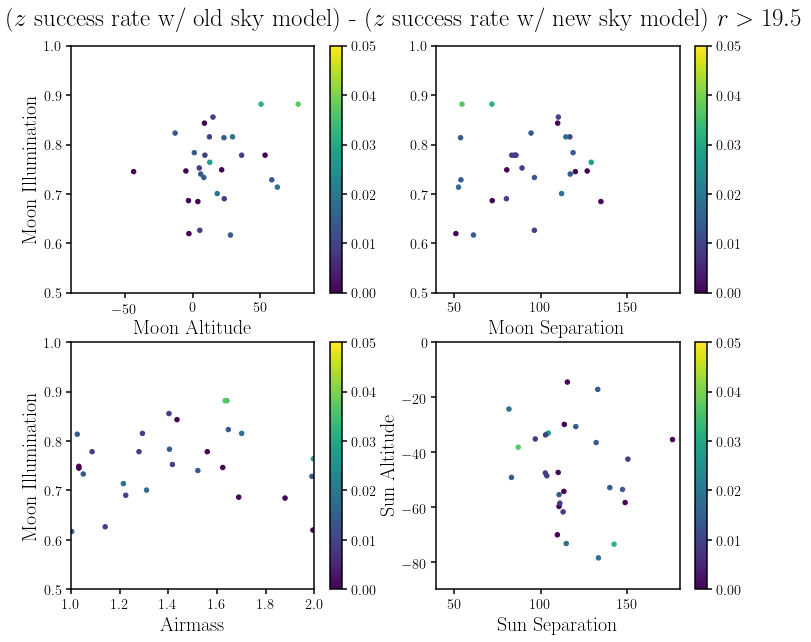

In [55]:
fig = plt.figure(figsize=(12,10))
bkgd = fig.add_subplot(111, frameon=False)
sub = fig.add_subplot(221)
scat = sub.scatter(exps['MOONALT'][bgs_iexps], exps['MOONFRAC'][bgs_iexps], 
                   c=(zs_19_5_old-zs_19_5_new), s=20, vmin=0.0, vmax=0.05)
sub.set_xlabel('Moon Altitude', fontsize=20)
sub.set_xlim([-90., 90.])
sub.set_ylabel('Moon Illumination', fontsize=20)
sub.set_ylim([0.5, 1.])
fig.colorbar(scat)

sub = fig.add_subplot(222)
scat = sub.scatter(exps['MOONSEP'][bgs_iexps], exps['MOONFRAC'][bgs_iexps], 
                   c=(zs_19_5_old-zs_19_5_new), s=20, vmin=0.0, vmax=0.05)
sub.set_xlabel('Moon Separation', fontsize=20)
sub.set_xlim([40., 180.])
sub.set_ylim([0.5, 1.])
#sub.set_title('(new Sky Model) / (old Sky Model) at $4600A$', pad=30, fontsize=25)
fig.colorbar(scat)

sub = fig.add_subplot(223)
scat = sub.scatter(exps['AIRMASS'][bgs_iexps], exps['MOONFRAC'][bgs_iexps], 
                   c=(zs_19_5_old-zs_19_5_new), s=20, vmin=0.0, vmax=0.05)
sub.set_xlabel('Airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylabel('Moon Illumination', fontsize=20)
sub.set_ylim([0.5, 1.])
fig.colorbar(scat)

sub = fig.add_subplot(224)
scat = sub.scatter(exps['SUNSEP'][bgs_iexps], exps['SUNALT'][bgs_iexps], 
                   c=(zs_19_5_old-zs_19_5_new), s=20, vmin=0., vmax=0.05)
sub.set_xlabel('Sun Separation', fontsize=20)
sub.set_xlim([40., 180.])
sub.set_ylabel('Sun Altitude', fontsize=20)
sub.set_ylim([-90., 0.])
fig.colorbar(scat)

bkgd.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
bkgd.set_title('($z$ success rate w/ old sky model) - ($z$ success rate w/ new sky model) $r > 19.5$', pad=20, fontsize=25)

Text(0.5,1,'($z$ success rate w/ old sky model) - ($z$ success rate w/ new sky model) $r > 20.0$')

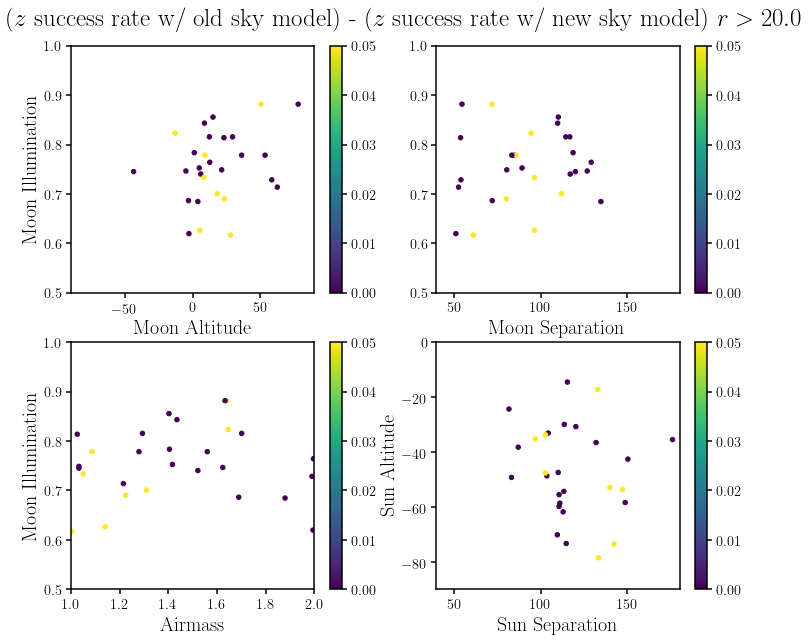

In [56]:
fig = plt.figure(figsize=(12,10))
bkgd = fig.add_subplot(111, frameon=False)
sub = fig.add_subplot(221)
scat = sub.scatter(exps['MOONALT'][bgs_iexps], exps['MOONFRAC'][bgs_iexps], 
                   c=(zs_20_0_old-zs_20_0_new), s=20, vmin=0.0, vmax=0.05)
sub.set_xlabel('Moon Altitude', fontsize=20)
sub.set_xlim([-90., 90.])
sub.set_ylabel('Moon Illumination', fontsize=20)
sub.set_ylim([0.5, 1.])
fig.colorbar(scat)

sub = fig.add_subplot(222)
scat = sub.scatter(exps['MOONSEP'][bgs_iexps], exps['MOONFRAC'][bgs_iexps], 
                   c=(zs_20_0_old-zs_20_0_new), s=20, vmin=0.0, vmax=0.05)
sub.set_xlabel('Moon Separation', fontsize=20)
sub.set_xlim([40., 180.])
sub.set_ylim([0.5, 1.])
#sub.set_title('(new Sky Model) / (old Sky Model) at $4600A$', pad=30, fontsize=25)
fig.colorbar(scat)

sub = fig.add_subplot(223)
scat = sub.scatter(exps['AIRMASS'][bgs_iexps], exps['MOONFRAC'][bgs_iexps], 
                   c=(zs_20_0_old-zs_20_0_new), s=20, vmin=0.0, vmax=0.05)
sub.set_xlabel('Airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylabel('Moon Illumination', fontsize=20)
sub.set_ylim([0.5, 1.])
fig.colorbar(scat)

sub = fig.add_subplot(224)
scat = sub.scatter(exps['SUNSEP'][bgs_iexps], exps['SUNALT'][bgs_iexps], 
                   c=(zs_20_0_old-zs_20_0_new), s=20, vmin=0., vmax=0.05)
sub.set_xlabel('Sun Separation', fontsize=20)
sub.set_xlim([40., 180.])
sub.set_ylabel('Sun Altitude', fontsize=20)
sub.set_ylim([-90., 0.])
fig.colorbar(scat)

bkgd.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
bkgd.set_title('($z$ success rate w/ old sky model) - ($z$ success rate w/ new sky model) $r > 20.0$', pad=20, fontsize=25)